# UTD-MHAD Inertial Standardization QA

Load `(raw, standardized)` accelerometer clip pairs from training subjects, check per-channel statistics,
and visualize a few random examples to confirm the preprocessing.


In [7]:
from pathlib import Path
import numpy as np
import random
import matplotlib.pyplot as plt
import yaml

DATA_ROOT = (Path.cwd() / '../datasets' / 'UTD_MHAD').resolve()
CONFIG_PATH = (Path.cwd() / '../conf' / 'data' / 'mhad.yaml').resolve()
print('Config path:', CONFIG_PATH)
print('Data root:', DATA_ROOT)
assert DATA_ROOT.exists(), f'Missing dataset dir: {DATA_ROOT}'
with CONFIG_PATH.open('r') as f:
    cfg = yaml.safe_load(f) or {}
TRAIN_SUBJECTS = cfg.get('train_subjects', [])
print('Train subjects:', TRAIN_SUBJECTS)

Config path: /Users/parham/Desktop/The Semester/code/conf/data/mhad.yaml
Data root: /Users/parham/Desktop/The Semester/code/datasets/UTD_MHAD
Train subjects: ['s1', 's2', 's3', 's4']


In [8]:
def resolve_std_path(raw_path: Path) -> Path | None:
    name = raw_path.name
    if name.endswith('_inertial.npy'):
        candidate = raw_path.with_name(name.replace('_inertial.npy', '_inertial_std.npy'))
        if candidate.exists():
            return candidate
    candidate = raw_path.with_name(name + '_inertial_std.npy')
    return candidate if candidate.exists() else None

def collect_clip_pairs(subjects):
    pairs = []
    for subject in subjects:
        subj_dir = DATA_ROOT / subject
        if not subj_dir.is_dir():
            continue
        for raw_path in sorted(subj_dir.glob(f'a*_{subject}_t*_inertial.npy')):
            std_path = resolve_std_path(raw_path)
            if std_path is not None:
                pairs.append((raw_path, std_path))
    return pairs

subjects = TRAIN_SUBJECTS if TRAIN_SUBJECTS else [d.name for d in DATA_ROOT.iterdir() if d.is_dir()]
clip_pairs = collect_clip_pairs(subjects)
print(f'Collected {len(clip_pairs)} clip pairs.')

Collected 335 clip pairs.


In [9]:
sum_channels = np.zeros(3, dtype=np.float64)
sum_sq_channels = np.zeros(3, dtype=np.float64)
count = 0
for _, std_path in clip_pairs:
    std = np.load(std_path)
    if std.ndim != 2:
        continue
    if std.shape[0] != 3 and std.shape[1] == 3:
        std = std.T
    std = std[:3, :]
    sum_channels += std.sum(axis=1)
    sum_sq_channels += (std ** 2).sum(axis=1)
    count += std.shape[1]
mean = sum_channels / count
var = sum_sq_channels / count - mean ** 2
std_dev = np.sqrt(np.maximum(var, 1e-12))
print('Global mean per channel:', mean)
print('Global std per channel:', std_dev)

Global mean per channel: [-8.01982358e-08 -5.40725278e-08 -9.39655670e-09]
Global std per channel: [0.99999994 1.00000004 0.99999995]


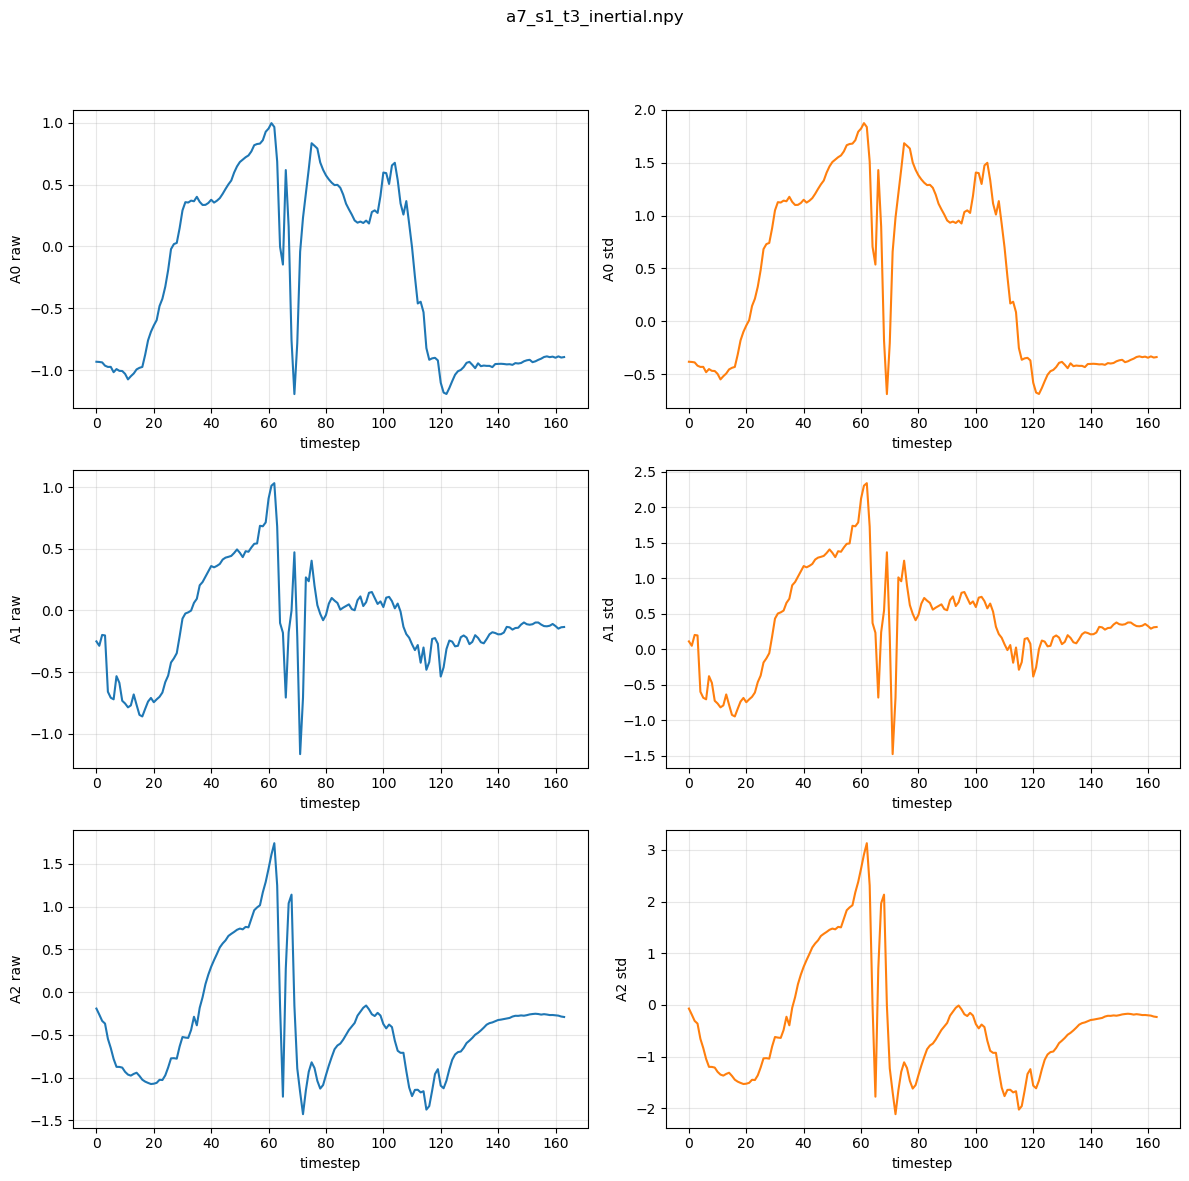

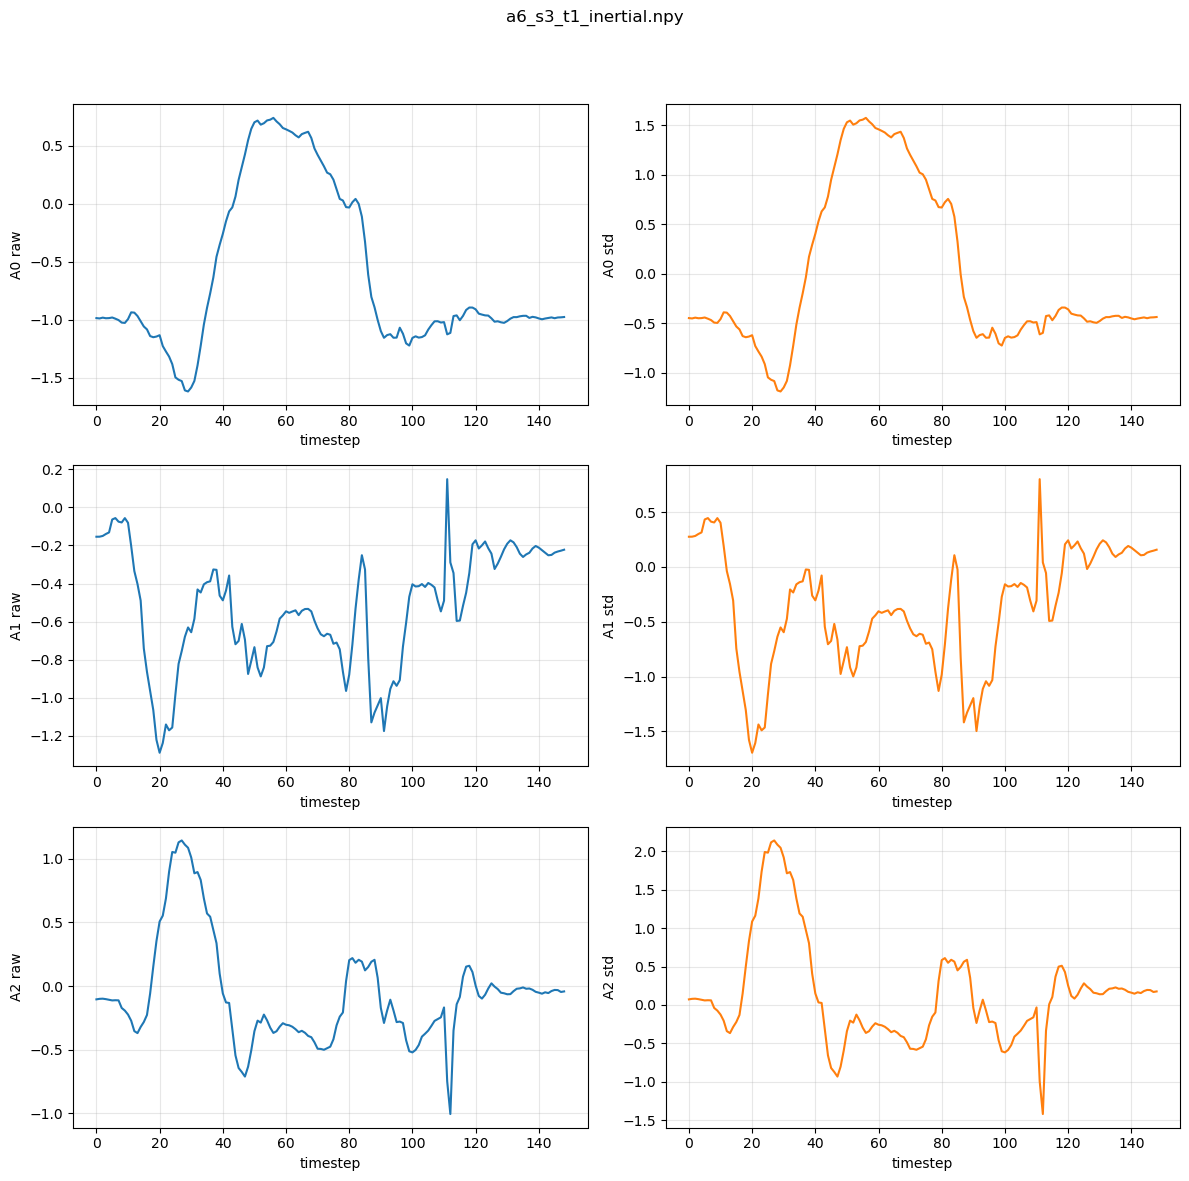

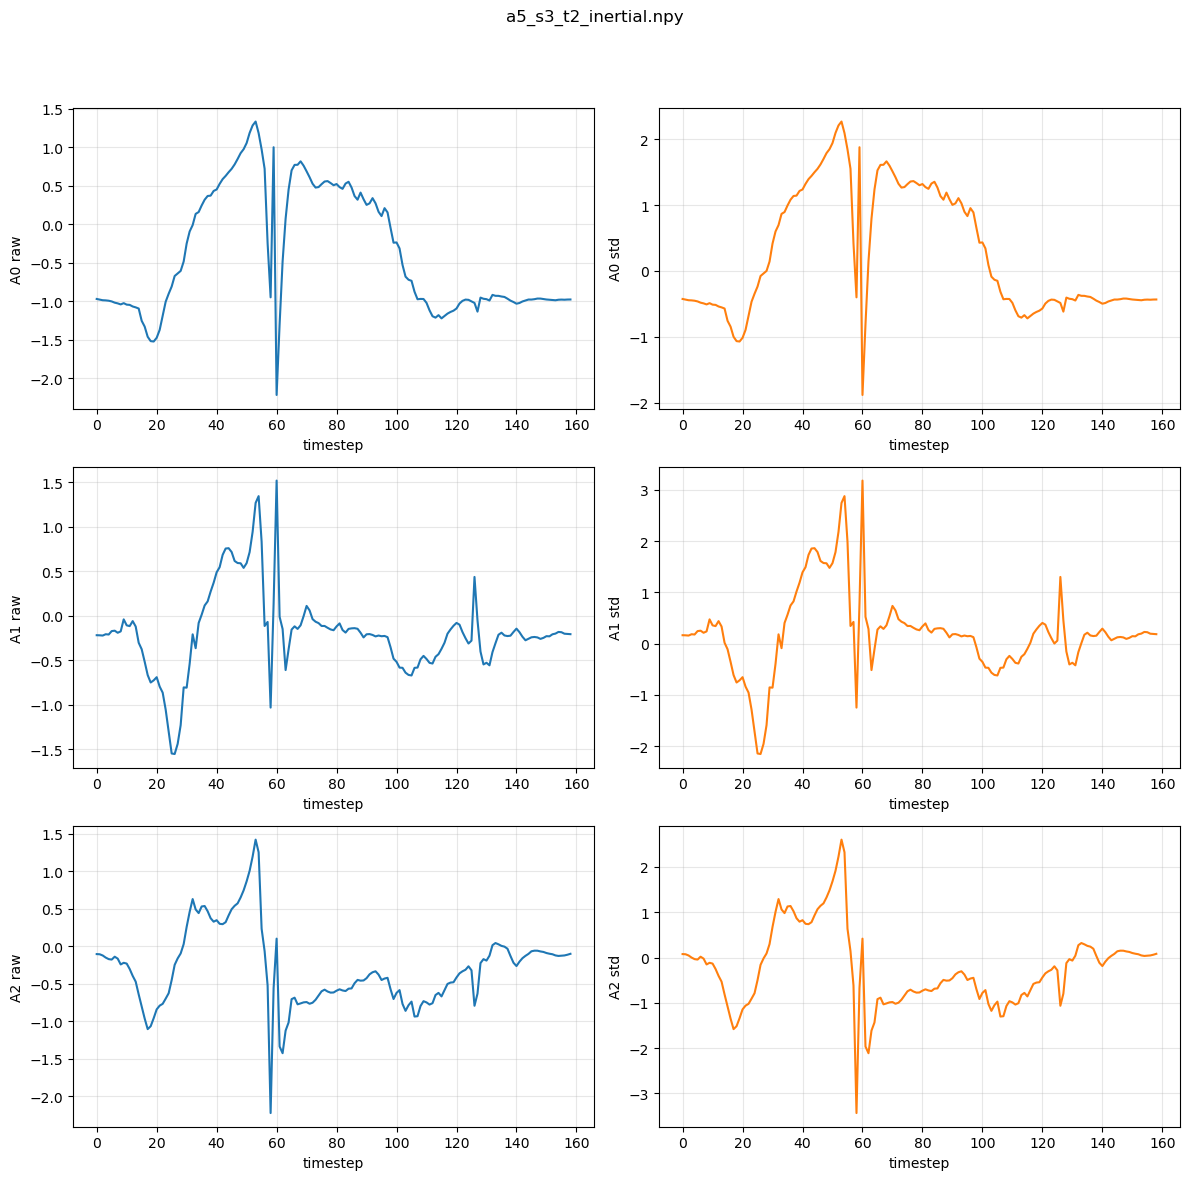

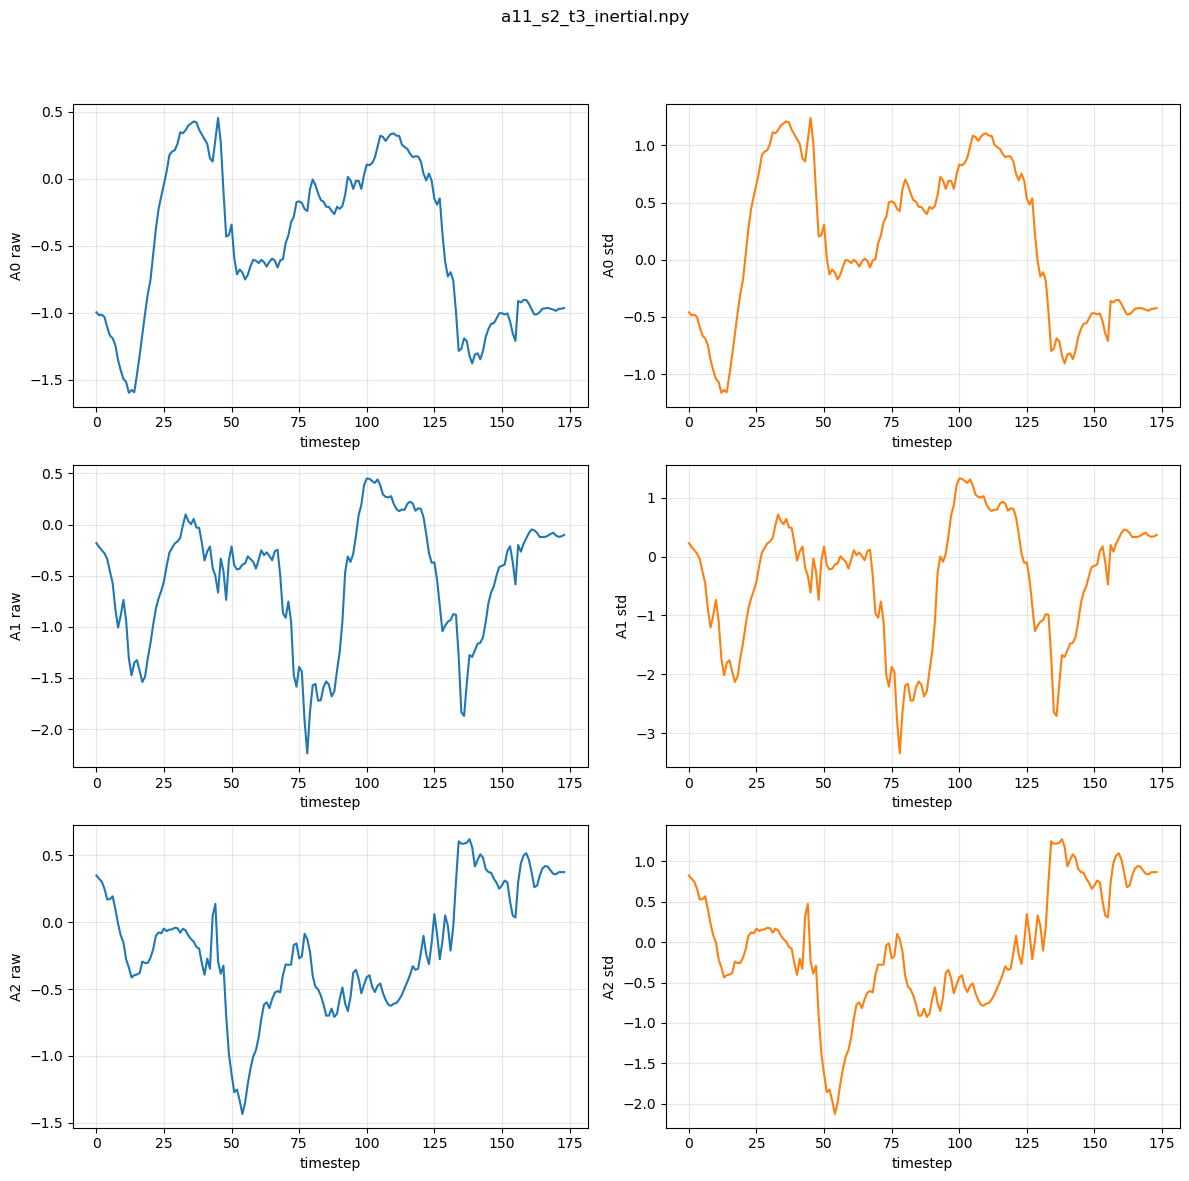

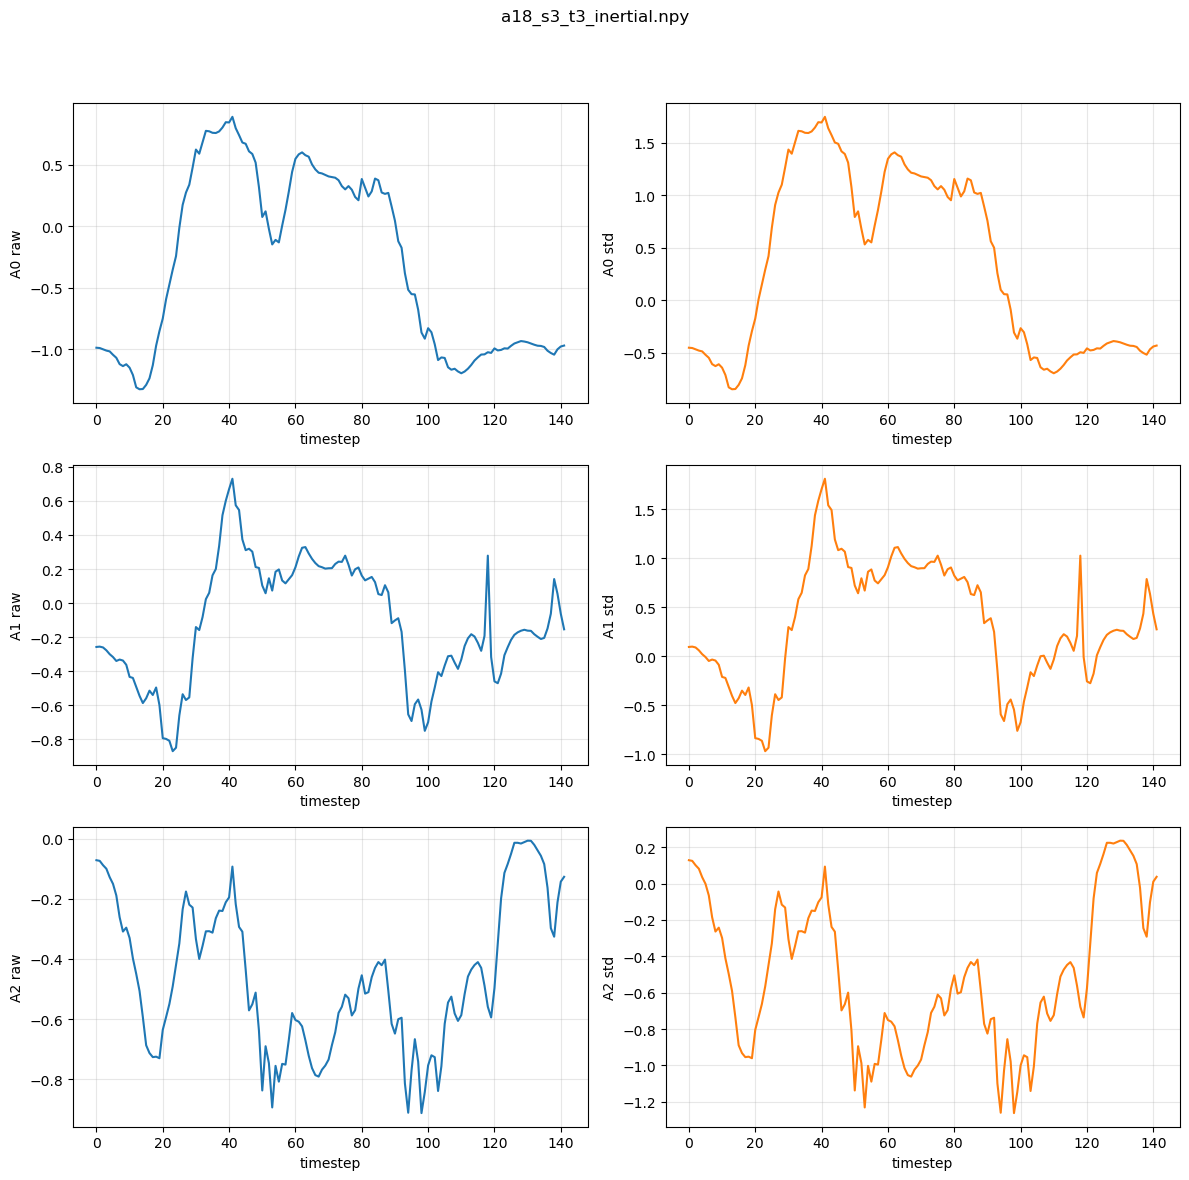

In [14]:
def load_raw_channel_first(raw_path: Path) -> np.ndarray:
    arr = np.load(raw_path)
    if arr.ndim != 2:
        raise ValueError(f'Unexpected shape {arr.shape}')
    arr = arr[:, :3] if arr.shape[1] >= 3 else arr
    if arr.shape[1] == 3 and arr.shape[0] != 3:
        arr = arr.T
    if arr.shape[0] != 3:
        arr = arr[:3, :]
    return arr

def load_std_channel_first(std_path: Path) -> np.ndarray:
    arr = np.load(std_path)
    if arr.ndim != 2:
        raise ValueError(f'Unexpected shape {arr.shape}')
    if arr.shape[0] != 3 and arr.shape[1] == 3:
        arr = arr.T
    return arr[:3, :]

def plot_clip_pair(raw_path: Path, std_path: Path, axes=(0, 1, 2)):
    raw = load_raw_channel_first(raw_path)
    std = load_std_channel_first(std_path)
    fig, axs = plt.subplots(len(axes), 2, figsize=(12, 4 * len(axes)))
    fig.suptitle(raw_path.name)
    for row, axis in enumerate(axes):
        axs[row, 0].plot(np.arange(raw.shape[1]), raw[axis], color='tab:blue')
        axs[row, 0].set_ylabel(f'A{axis} raw')
        axs[row, 0].set_xlabel('timestep')
        axs[row, 0].grid(True, alpha=0.3)
        axs[row, 1].plot(np.arange(std.shape[1]), std[axis], color='tab:orange')
        axs[row, 1].set_ylabel(f'A{axis} std')
        axs[row, 1].set_xlabel('timestep')
        axs[row, 1].grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

random.seed(100)
num_samples = min(5, len(clip_pairs))
for raw_path, std_path in random.sample(clip_pairs, num_samples):
    plot_clip_pair(raw_path, std_path)